## Obesity prediction Model

1. Problem
2. Data
3. Evaluation
4. Metrics

## 1. Problem
`Create a model to identify probability of a person developing obesity and underlying conditions`

## 2. Data 
Data was downloaded from Kaggle's Multi-Class Prediction of Obesity Competition - https://www.kaggle.com/competitions/playground-series-s4e2/data

## 3. Evaluation
Submissions are evaluated using the `accuracy score`.

## Metrics

In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import lazypredict
from lazypredict.Supervised import LazyClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
# from autofeatselect import CorrelationCalculator, FeatureSelector, AutoFeatureSelect
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

In [14]:
df = pd.read_csv('train.csv')
df.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [15]:
# Let's check some important information about our data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   Gender                          20758 non-null  object 
 2   Age                             20758 non-null  float64
 3   Height                          20758 non-null  float64
 4   Weight                          20758 non-null  float64
 5   family_history_with_overweight  20758 non-null  object 
 6   FAVC                            20758 non-null  object 
 7   FCVC                            20758 non-null  float64
 8   NCP                             20758 non-null  float64
 9   CAEC                            20758 non-null  object 
 10  SMOKE                           20758 non-null  object 
 11  CH2O                            20758 non-null  float64
 12  SCC                             

In [16]:
df.isna().sum()

id                                0
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

### Let's visualize our target values 

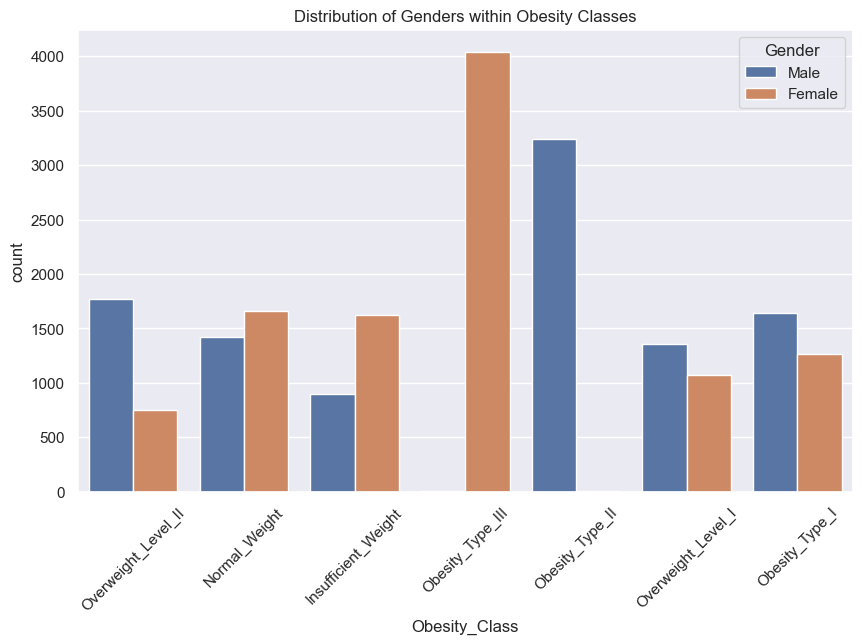

In [37]:
data = {
    'Gender': df.Gender,
    'Obesity_Class': df.NObeyesdad
}
gndr = pd.DataFrame(data)

# Create a countplot with Gender and Obesity_Class
plt.figure(figsize=(10, 6))
sns.countplot(data=gndr, x='Obesity_Class', hue='Gender')
plt.title('Distribution of Genders within Obesity Classes')
plt.xticks(rotation=45)
plt.show();

## Data Preprocessing 

In [17]:
def preprocessing(df):
    gender_encoding = {
    'Male' : 0,
    'Female' : 1
    }
    MTRANS_encoding = {
    'Public_Transportation' : 0.9,
    'Automobile' : 1,
    'Walking' : 0.1,
    'Motorbike' : 0.6,
    'Bike' : 0.3
    }
    yes_no_encoding = {
    'yes' : 1,
    'no' : 0
    }
    encoding = {
    'Sometimes': 0.5,
    'Frequently': 0.80,
    'Always': 1.0,
    'no': 0
    }
    
    # Apply the encoding to the specified columns
    df['family_history_with_overweight'] = df['family_history_with_overweight'].replace(yes_no_encoding)
    df['FAVC'] = df['FAVC'].replace(yes_no_encoding)
    df['SMOKE'] = df['SMOKE'].replace(yes_no_encoding)
    df['SCC'] = df['SCC'].replace(yes_no_encoding)
    df['MTRANS'] = df['MTRANS'].replace(MTRANS_encoding)
    df['Gender'] = df['Gender'].replace(gender_encoding)
    df['CAEC'] = df['CAEC'].replace(encoding)
    df['CALC'] = df['CALC'].replace(encoding)
    return df

In [18]:
df_tmp = df.copy()
df_tmp

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,20753,Male,25.137087,1.766626,114.187096,yes,yes,2.919584,3.000000,Sometimes,no,2.151809,no,1.330519,0.196680,Sometimes,Public_Transportation,Obesity_Type_II
20754,20754,Male,18.000000,1.710000,50.000000,no,yes,3.000000,4.000000,Frequently,no,1.000000,no,2.000000,1.000000,Sometimes,Public_Transportation,Insufficient_Weight
20755,20755,Male,20.101026,1.819557,105.580491,yes,yes,2.407817,3.000000,Sometimes,no,2.000000,no,1.158040,1.198439,no,Public_Transportation,Obesity_Type_II
20756,20756,Male,33.852953,1.700000,83.520113,yes,yes,2.671238,1.971472,Sometimes,no,2.144838,no,0.000000,0.973834,no,Automobile,Overweight_Level_II


In [19]:
df_tmp = preprocessing(df_tmp)
df_tmp

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,0,24.443011,1.699998,81.669950,1,1,2.000000,2.983297,0.5,0,2.763573,0,0.000000,0.976473,0.5,0.9,Overweight_Level_II
1,1,1,18.000000,1.560000,57.000000,1,1,2.000000,3.000000,0.8,0,2.000000,0,1.000000,1.000000,0.0,1.0,Normal_Weight
2,2,1,18.000000,1.711460,50.165754,1,1,1.880534,1.411685,0.5,0,1.910378,0,0.866045,1.673584,0.0,0.9,Insufficient_Weight
3,3,1,20.952737,1.710730,131.274851,1,1,3.000000,3.000000,0.5,0,1.674061,0,1.467863,0.780199,0.5,0.9,Obesity_Type_III
4,4,0,31.641081,1.914186,93.798055,1,1,2.679664,1.971472,0.5,0,1.979848,0,1.967973,0.931721,0.5,0.9,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,20753,0,25.137087,1.766626,114.187096,1,1,2.919584,3.000000,0.5,0,2.151809,0,1.330519,0.196680,0.5,0.9,Obesity_Type_II
20754,20754,0,18.000000,1.710000,50.000000,0,1,3.000000,4.000000,0.8,0,1.000000,0,2.000000,1.000000,0.5,0.9,Insufficient_Weight
20755,20755,0,20.101026,1.819557,105.580491,1,1,2.407817,3.000000,0.5,0,2.000000,0,1.158040,1.198439,0.0,0.9,Obesity_Type_II
20756,20756,0,33.852953,1.700000,83.520113,1,1,2.671238,1.971472,0.5,0,2.144838,0,0.000000,0.973834,0.0,1.0,Overweight_Level_II


#### Now as we have our data ready let's sort it out and leave only important data to avoid overfitting and unnecessary usage of energy and time

## Feature selection

In [20]:
X = df_tmp.drop('NObeyesdad', axis=1)
y = df_tmp['NObeyesdad']

In [21]:
# #Setting numeric & categorical features for further analysis
# response = 'NObeyesdad'
# cat_feats = [c for c in X.columns if '_cat' in c]
# bin_feats = [c for c in X.columns if '_bin' in c]
# cat_feats = cat_feats + bin_feats
# num_feats = [c for c in df.columns if c not in cat_feats+[response]]

# X[num_feats] = X[num_feats].astype('float')
# X[cat_feats] = X[cat_feats].astype('object')

# X.replace(-1, np.nan, inplace=True)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test

(          id  Gender        Age    Height      Weight  \
 9958    9958       0  17.000000  1.770000   97.000000   
 7841    7841       0  22.667596  1.753389   54.877111   
 9293    9293       0  21.838323  1.819867  122.024954   
 15209  15209       1  41.000000  1.580000   80.000000   
 16515  16515       0  23.000000  1.800000   95.000000   
 ...      ...     ...        ...       ...         ...   
 11284  11284       1  18.000000  1.722461   80.442775   
 11964  11964       0  22.000000  1.750000   95.000000   
 5390    5390       0  21.000000  1.620000   68.000000   
 860      860       1  26.000000  1.650125  111.939671   
 15795  15795       0  37.997912  1.774330  107.998815   
 
        family_history_with_overweight  FAVC      FCVC       NCP  CAEC  SMOKE  \
 9958                                1     1  3.000000  3.000000   1.0      0   
 7841                                1     1  2.000000  4.000000   0.5      0   
 9293                                1     1  3.000000  2.8

## Let's use Lazypredict to find out the best model to use

In [26]:
# initiate the classifier
clf = LazyClassifier(verbose=0, ignore_warnings=True, predictions=True)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [01:54<00:00,  3.95s/it]


In [27]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.90,0.89,None,0.90,1.26
RandomForestClassifier,0.90,0.88,None,0.90,2.04
BaggingClassifier,0.88,0.87,None,0.88,1.20
ExtraTreesClassifier,0.88,0.87,None,0.88,1.55
SVC,0.86,0.84,None,0.86,3.34
DecisionTreeClassifier,0.85,0.83,None,0.85,0.21
LinearDiscriminantAnalysis,0.82,0.80,None,0.82,1.81
NuSVC,0.80,0.78,None,0.80,12.54
ExtraTreeClassifier,0.76,0.74,None,0.76,0.07


We can see that `LGBMClassifier` and `RandomForestClassifier` are two top performing models. 

Let's analyze them and see whether we can use them further

## LGBMClassifier

In [29]:
# Let's try to use LGBMClassifier
lgbm = lgb.LGBMClassifier(random_state=42)

# Fit the model
lgbm.fit(X_train, y_train)

# Score the model
lgbm_score = lgbm.score(X_test, y_test)
lgbm_score

0.9024566473988439

## Hyperparameter tuning with `RandomizedSearchCV`

In [36]:
lgbm_dist = {
    'num_leaves': sp_randint(6, 50), 
    'min_child_samples': sp_randint(100, 500), 
    'min_child_weight': sp_uniform(0.01, 10), 
    'subsample': sp_uniform(0.2, 0.8), 
    'colsample_bytree': sp_uniform(0.4, 0.6),
    'reg_alpha': sp_uniform(0.01, 0.4),
    'reg_lambda': sp_uniform(0.01, 0.4),
    'learning_rate': sp_uniform(0.01, 0.3)
}

In [39]:
# Let's tune
# Initialize RandomizedSearchCV
n_iter_search = 20  # Number of parameter settings sampled
random_search_lgbm = RandomizedSearchCV(lgbm, param_distributions=lgbm_dist, 
                                   n_iter=n_iter_search, scoring='accuracy', 
                                   cv=5, random_state=42, verbose=2)

# fit tuned model
random_search_lgbm.fit(X_train, y_train)

# Score the model
random_search_lgbm_score = random_search_lgbm.score(X_test, y_test)
random_search_lgbm_score

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] colsample_bytree=0.6247240713084175, learning_rate=0.2952142919229748, min_child_samples=206, min_child_weight=7.806910002727692, num_leaves=26, reg_alpha=0.07240745617697461, reg_lambda=0.07239780813448106, subsample=0.24646688973455957 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  colsample_bytree=0.6247240713084175, learning_rate=0.2952142919229748, min_child_samples=206, min_child_weight=7.806910002727692, num_leaves=26, reg_alpha=0.07240745617697461, reg_lambda=0.07239780813448106, subsample=0.24646688973455957, total=   0.6s
[CV] colsample_bytree=0.6247240713084175, learning_rate=0.2952142919229748, min_child_samples=206, min_child_weight=7.806910002727692, num_leaves=26, reg_alpha=0.07240745617697461, reg_lambda=0.07239780813448106, subsample=0.24646688973455957 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  colsample_bytree=0.6247240713084175, learning_rate=0.2952142919229748, min_child_samples=206, min_child_weight=7.806910002727692, num_leaves=26, reg_alpha=0.07240745617697461, reg_lambda=0.07239780813448106, subsample=0.24646688973455957, total=   0.6s
[CV] colsample_bytree=0.6247240713084175, learning_rate=0.2952142919229748, min_child_samples=206, min_child_weight=7.806910002727692, num_leaves=26, reg_alpha=0.07240745617697461, reg_lambda=0.07239780813448106, subsample=0.24646688973455957 
[CV]  colsample_bytree=0.6247240713084175, learning_rate=0.2952142919229748, min_child_samples=206, min_child_weight=7.806910002727692, num_leaves=26, reg_alpha=0.07240745617697461, reg_lambda=0.07239780813448106, subsample=0.24646688973455957, total=   0.5s
[CV] colsample_bytree=0.6247240713084175, learning_rate=0.2952142919229748, min_child_samples=206, min_child_weight=7.806910002727692, num_leaves=26, reg_alpha=0.07240745617697461, reg_lambda=0.07239780813448106, subsample=0.2464668897345

[CV]  colsample_bytree=0.42799939792816927, learning_rate=0.30212665565243774, min_child_samples=370, min_child_weight=4.5706998421703595, num_leaves=49, reg_alpha=0.21569377536544465, reg_lambda=0.246965827544817, subsample=0.2371603301759982, total=   0.6s
[CV] colsample_bytree=0.42799939792816927, learning_rate=0.30212665565243774, min_child_samples=370, min_child_weight=4.5706998421703595, num_leaves=49, reg_alpha=0.21569377536544465, reg_lambda=0.246965827544817, subsample=0.2371603301759982 
[CV]  colsample_bytree=0.42799939792816927, learning_rate=0.30212665565243774, min_child_samples=370, min_child_weight=4.5706998421703595, num_leaves=49, reg_alpha=0.21569377536544465, reg_lambda=0.246965827544817, subsample=0.2371603301759982, total=   0.6s
[CV] colsample_bytree=0.764526911140863, learning_rate=0.06115723710618746, min_child_samples=266, min_child_weight=0.1426496115986653, num_leaves=30, reg_alpha=0.39625281322982375, reg_lambda=0.3333589392465845, subsample=0.4436910153386

[CV]  colsample_bytree=0.6698524800218595, learning_rate=0.12854507080054434, min_child_samples=369, min_child_weight=7.282719958564209, num_leaves=20, reg_alpha=0.0453970008207678, reg_lambda=0.08839314496765809, subsample=0.23618183112843047, total=   0.5s
[CV] colsample_bytree=0.6698524800218595, learning_rate=0.12854507080054434, min_child_samples=369, min_child_weight=7.282719958564209, num_leaves=20, reg_alpha=0.0453970008207678, reg_lambda=0.08839314496765809, subsample=0.23618183112843047 
[CV]  colsample_bytree=0.6698524800218595, learning_rate=0.12854507080054434, min_child_samples=369, min_child_weight=7.282719958564209, num_leaves=20, reg_alpha=0.0453970008207678, reg_lambda=0.08839314496765809, subsample=0.23618183112843047, total=   0.6s
[CV] colsample_bytree=0.6698524800218595, learning_rate=0.12854507080054434, min_child_samples=369, min_child_weight=7.282719958564209, num_leaves=20, reg_alpha=0.0453970008207678, reg_lambda=0.08839314496765809, subsample=0.2361818311284

[CV]  colsample_bytree=0.8892768570729005, learning_rate=0.22205720315428515, min_child_samples=262, min_child_weight=7.911755405312056, num_leaves=10, reg_alpha=0.38052035140533963, reg_lambda=0.2704308102007778, subsample=0.9319677404350246, total=   0.4s
[CV] colsample_bytree=0.8892768570729005, learning_rate=0.22205720315428515, min_child_samples=262, min_child_weight=7.911755405312056, num_leaves=10, reg_alpha=0.38052035140533963, reg_lambda=0.2704308102007778, subsample=0.9319677404350246 
[CV]  colsample_bytree=0.8892768570729005, learning_rate=0.22205720315428515, min_child_samples=262, min_child_weight=7.911755405312056, num_leaves=10, reg_alpha=0.38052035140533963, reg_lambda=0.2704308102007778, subsample=0.9319677404350246, total=   0.4s
[CV] colsample_bytree=0.8892768570729005, learning_rate=0.22205720315428515, min_child_samples=262, min_child_weight=7.911755405312056, num_leaves=10, reg_alpha=0.38052035140533963, reg_lambda=0.2704308102007778, subsample=0.9319677404350246

[CV]  colsample_bytree=0.5536409936567944, learning_rate=0.022130076861529402, min_child_samples=306, min_child_weight=4.285410183585496, num_leaves=47, reg_alpha=0.18573460074630807, reg_lambda=0.09068768093415848, subsample=0.9166108765388155, total=   0.6s
[CV] colsample_bytree=0.685222133909267, learning_rate=0.17898267159291512, min_child_samples=487, min_child_weight=9.08566473926093, num_leaves=28, reg_alpha=0.2517669517111269, reg_lambda=0.22593643652066928, subsample=0.36244897978781554 
[CV]  colsample_bytree=0.685222133909267, learning_rate=0.17898267159291512, min_child_samples=487, min_child_weight=9.08566473926093, num_leaves=28, reg_alpha=0.2517669517111269, reg_lambda=0.22593643652066928, subsample=0.36244897978781554, total=   0.4s
[CV] colsample_bytree=0.685222133909267, learning_rate=0.17898267159291512, min_child_samples=487, min_child_weight=9.08566473926093, num_leaves=28, reg_alpha=0.2517669517111269, reg_lambda=0.22593643652066928, subsample=0.36244897978781554 

[CV]  colsample_bytree=0.9440970649274524, learning_rate=0.09163967481539059, min_child_samples=382, min_child_weight=4.281077886262563, num_leaves=18, reg_alpha=0.3542922333025374, reg_lambda=0.012780852212476282, subsample=0.6085978420620526, total=   0.5s
[CV] colsample_bytree=0.9440970649274524, learning_rate=0.09163967481539059, min_child_samples=382, min_child_weight=4.281077886262563, num_leaves=18, reg_alpha=0.3542922333025374, reg_lambda=0.012780852212476282, subsample=0.6085978420620526 
[CV]  colsample_bytree=0.9440970649274524, learning_rate=0.09163967481539059, min_child_samples=382, min_child_weight=4.281077886262563, num_leaves=18, reg_alpha=0.3542922333025374, reg_lambda=0.012780852212476282, subsample=0.6085978420620526, total=   0.5s
[CV] colsample_bytree=0.9440970649274524, learning_rate=0.09163967481539059, min_child_samples=382, min_child_weight=4.281077886262563, num_leaves=18, reg_alpha=0.3542922333025374, reg_lambda=0.012780852212476282, subsample=0.608597842062

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   54.3s finished


0.9077552986512524

### Accuracy increased to 0.9078

## RandomForestClassifier

In [34]:
## RandomForestClassifier
rf = RandomForestClassifier()

# Fit the model
rf.fit(X_train, y_train)

# Score the model
rf_score = rf.score(X_test, y_test)
rf_score

0.8959537572254336

## Hyperparameter tuning for RandomForestClassifier using `RandomizedSearchCV`

In [35]:
# Let's create a dictionary for hyperparameter tuning
rf_dist = {
    'n_estimators': sp_randint(100, 1000),  # Number of trees in the forest
    'max_depth': sp_randint(3, 30),         # Maximum depth of the tree
    'min_samples_split': sp_randint(2, 11), # Minimum number of samples required to split an internal node
    'min_samples_leaf': sp_randint(1, 11),  # Minimum number of samples required to be at a leaf node
    'max_features': sp_uniform(0.1, 0.99),  # Number of features to consider when looking for the best split
    'bootstrap': [True, False],             # Method for sampling data points
    'criterion': ['gini', 'entropy'],       # The function to measure the quality of a split
    'max_leaf_nodes': sp_randint(20, 1000), # Grow trees with max_leaf_nodes in best-first fashion
    'min_impurity_decrease': sp_uniform(0.0001, 0.1)  # A node will be split if this split induces a decrease of the impurity greater than or equal to this value.
}

In [40]:
# Tuning RandomForestClassifier
random_search_rf = RandomizedSearchCV(rf, param_distributions=rf_dist,
                                      n_iter=n_iter_search, scoring='accuracy',
                                      cv=5, random_state=42)

# Let's fit the result of tuning 
random_search_rf.fit(X_train, y_train)

# Score the model
random_search_rf_score = random_search_rf.score(X_test, y_test)
random_search_rf_score

0.8841522157996147

## Best Hyperparameters for LGBMClassifier

In [42]:
# LGBMClassifier
random_search_lgbm.best_params_

{'colsample_bytree': 0.5648330757940385,
 'learning_rate': 0.17837302775431035,
 'min_child_samples': 326,
 'min_child_weight': 1.205942459383017,
 'num_leaves': 19,
 'reg_alpha': 0.34956552970643356,
 'reg_lambda': 0.2986918084659493,
 'subsample': 0.3887879357991646}

In [54]:
lgbm = lgb.LGBMClassifier(colsample_bytree=0.5648330757940385,
                          learning_rate=0.17837302775431035,
                          min_child_samples=326,
                          min_child_weight=1.205942459383017,
                          num_leaves=19,
                          reg_alpha=0.34956552970643356,
                          reg_lambda=0.2986918084659493,
                          subsample=0.3887879357991646,
                          random_state=43)

# Fit the best tuned model
lgbm.fit(X_train, y_train)

# Score the model
lgbm_best_score = lgbm.score(X_test, y_test)
lgbm_best_score

0.9079961464354528

## Making predictions

In [55]:
# import the test data
test_df = pd.read_csv('test.csv')
test_df = preprocessing(test_df) # Encode
test_df

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,20758,0,26.90,1.85,120.64,1,1,2.94,3.00,0.50,0,2.83,0,0.86,0.00,0.50,0.90
1,20759,1,21.00,1.60,66.00,1,1,2.00,1.00,0.50,0,3.00,0,1.00,0.00,0.50,0.90
2,20760,1,26.00,1.64,111.60,1,1,3.00,3.00,0.50,0,2.62,0,0.00,0.25,0.50,0.90
3,20761,0,20.98,1.55,103.67,1,1,2.00,2.98,0.50,0,2.79,0,0.09,0.00,0.50,0.90
4,20762,1,26.00,1.63,104.84,1,1,3.00,3.00,0.50,0,2.65,0,0.00,0.74,0.50,0.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13835,34593,0,23.33,1.72,78.03,1,0,2.81,3.00,0.50,0,1.00,0,0.81,0.78,0.50,0.90
13836,34594,1,29.00,1.59,62.00,0,1,3.00,3.00,0.50,0,2.00,0,0.00,0.00,0.50,0.90
13837,34595,1,22.94,1.59,44.38,0,1,3.00,2.27,0.80,0,2.00,0,1.95,1.00,0.50,0.90
13838,34596,0,21.00,1.62,53.00,1,1,2.00,3.00,0.50,0,2.00,0,3.00,2.00,0.00,0.90


In [56]:
# LGBM
predictions_lgbm = lgbm.predict(test_df)
predictions_lgbm

array(['Obesity_Type_II', 'Overweight_Level_I', 'Obesity_Type_III', ...,
       'Insufficient_Weight', 'Normal_Weight', 'Obesity_Type_II'],
      dtype=object)

In [57]:
preds_df = pd.DataFrame()
preds_df['id'] = test_df['id']
preds_df['NObeyesdad'] = predictions_lgbm
preds_df

,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III
...,...,...
13835,34593,Overweight_Level_II
13836,34594,Overweight_Level_I
13837,34595,Insufficient_Weight
13838,34596,Normal_Weight


In [73]:
preds_df.to_csv('predictions_lazypredict.csv', index=False)

In [59]:
lgbm.feature_importances_

array([1208,  228, 1422, 1710, 2203,  161,   84,  692,  505,  142,    0,
        866,   52,  816,  727,  321,  166])

In [60]:
feature_importance_lgbm = dict(zip(X.columns, list(lgbm.feature_importances_)))

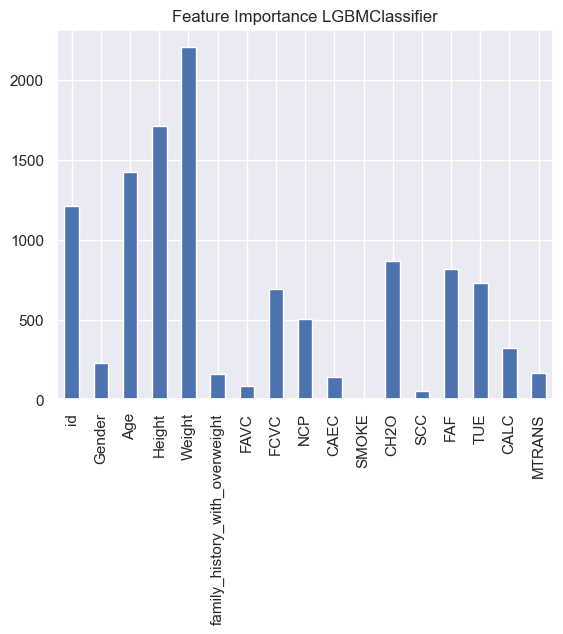

In [63]:
feature_df = pd.DataFrame(feature_importance_lgbm, index=[0])
feature_df.T.plot.bar(title='Feature Importance LGBMClassifier', legend=False);

In [64]:
new_df = df_tmp.copy()
new_df.drop('id', axis=1, inplace=True)
new_df.drop('family_history_with_overweight', axis=1, inplace=True)
new_df.drop('SMOKE', axis=1, inplace=True)
new_df.drop('SCC', axis=1, inplace=True)
new_df.drop('CAEC', axis=1, inplace=True)
new_df.drop('FAVC', axis=1, inplace=True)
new_df.drop('MTRANS', axis=1, inplace=True)
new_df

,Gender,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,CALC,NObeyesdad
0,0,24.44,1.70,81.67,2.00,2.98,2.76,0.00,0.98,0.50,Overweight_Level_II
1,1,18.00,1.56,57.00,2.00,3.00,2.00,1.00,1.00,0.00,Normal_Weight
2,1,18.00,1.71,50.17,1.88,1.41,1.91,0.87,1.67,0.00,Insufficient_Weight
3,1,20.95,1.71,131.27,3.00,3.00,1.67,1.47,0.78,0.50,Obesity_Type_III
4,0,31.64,1.91,93.80,2.68,1.97,1.98,1.97,0.93,0.50,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...
20753,0,25.14,1.77,114.19,2.92,3.00,2.15,1.33,0.20,0.50,Obesity_Type_II
20754,0,18.00,1.71,50.00,3.00,4.00,1.00,2.00,1.00,0.50,Insufficient_Weight
20755,0,20.10,1.82,105.58,2.41,3.00,2.00,1.16,1.20,0.00,Obesity_Type_II
20756,0,33.85,1.70,83.52,2.67,1.97,2.14,0.00,0.97,0.00,Overweight_Level_II


In [65]:
# Update X value
X = new_df.drop('NObeyesdad', axis=1)

In [66]:
# Update test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [67]:
X_train, X_test, y_train, y_test

(       Gender   Age  Height  Weight  FCVC  NCP  CH2O  FAF  TUE  CALC
 9958        0 17.00    1.77   97.00  3.00 3.00  2.00 3.00 1.00  0.00
 7841        0 22.67    1.75   54.88  2.00 4.00  2.00 2.00 1.00  0.00
 9293        0 21.84    1.82  122.02  3.00 2.88  1.65 0.74 0.00  0.50
 15209       1 41.00    1.58   80.00  2.00 3.00  1.00 0.00 0.00  0.50
 16515       0 23.00    1.80   95.00  3.00 3.00  3.00 2.00 1.00  0.80
 ...       ...   ...     ...     ...   ...  ...   ...  ...  ...   ...
 11284       1 18.00    1.72   80.44  2.63 2.56  1.84 0.29 0.72  0.00
 11964       0 22.00    1.75   95.00  3.00 3.00  2.00 3.00 0.00  0.50
 5390        0 21.00    1.62   68.00  2.00 3.00  3.00 2.00 0.00  0.50
 860         1 26.00    1.65  111.94  3.00 3.00  2.77 0.00 0.24  0.50
 15795       0 38.00    1.77  108.00  2.96 2.90  2.75 2.55 0.00  0.50
 
 [16606 rows x 10 columns],
        Gender   Age  Height  Weight  FCVC  NCP  CH2O  FAF  TUE  CALC
 10317       1 26.00    1.65  111.93  3.00 3.00  1.29 0.07 0

## Let's try Lazypredict once again on our filtered dataset

In [69]:
# Lazypredict
clf = LazyClassifier(verbose=0, ignore_warnings=True, predictions=True)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [01:18<00:00,  2.70s/it]


In [70]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.90,0.89,None,0.90,0.82
RandomForestClassifier,0.89,0.88,None,0.89,1.74
BaggingClassifier,0.88,0.87,None,0.88,0.48
ExtraTreesClassifier,0.88,0.87,None,0.88,1.29
SVC,0.86,0.85,None,0.86,2.31
DecisionTreeClassifier,0.85,0.83,None,0.85,0.12
NuSVC,0.82,0.80,None,0.82,9.74
LinearDiscriminantAnalysis,0.82,0.80,None,0.82,0.13
ExtraTreeClassifier,0.78,0.76,None,0.78,0.07


## Still the same

In [71]:
# LGBMCLassifier once again
lgbm = lgb.LGBMClassifier()

# Fit the model
lgbm.fit(X_train, y_train)

# Score the model
lgbm_filtered_data_score = lgbm.score(X_test, y_test)
lgbm_filtered_data_score

0.9014932562620424

In [72]:
# Let's try to tune
# Initialize RandomizedSearchCV
n_iter_search = 20  # Number of parameter settings sampled
random_search_lgbm = RandomizedSearchCV(lgbm, param_distributions=lgbm_dist, 
                                   n_iter=n_iter_search, scoring='accuracy', 
                                   cv=5, random_state=42, verbose=1)

# fit tuned model
random_search_lgbm.fit(X_train, y_train)

# Score the model
random_search_lgbm_score = random_search_lgbm.score(X_test, y_test)
random_search_lgbm_score

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   40.4s finished


0.8995664739884393

## We can see that filtered data actually didn't help, so let's stick to the previous results